# Explore

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np
import json

import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud

In [2]:
#Acquire prepped data

df = pd.read_json('cleaned_readmes.json')
df.head()

,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript
0,microsoft/react-native-windows,C++,react native for windows build native windows ...,react native window native window apps react h...,536,4288,False
1,microsoft/fast,TypeScript,fastbannergithub914pnghttpsstaticfastdesignass...,fastbannergithub914pnghttpsstaticfastdesignass...,981,8539,True
2,microsoft/Application-Insights-Workbooks,JSON,azure monitor workbook templates build statush...,azure monitor workbook template statushttpsgit...,385,3411,False
3,microsoft/gctoolkit,Java,microsoft gctoolkit gctoolkit is a set of libr...,microsoft gctoolkit gctoolkit set library anal...,349,2815,False
4,microsoft/winget-cli-restsource,C#,welcome to the wingetclirestsource repository ...,welcome wingetclirestsource repository buildin...,780,5557,False


## Split Data

In [3]:
#Splitting data
trainvalidate, test = train_test_split(df,stratify=df.is_TypeScript, test_size=.2, random_state=123)

train, validate = train_test_split(trainvalidate,stratify=trainvalidate.is_TypeScript, test_size=.2, random_state=123)


In [4]:
train.shape, validate.shape, test.shape

((876, 7), (220, 7), (274, 7))

### Q.) Do different programming languages use a different number of unique words?

In [5]:
#Take a look at the count and percentage of words 
languages = pd.concat([train.language.value_counts(),
                    train.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'percent']
languages

,n,percent
TypeScript,225,0.256849
C#,146,0.166667
Python,118,0.134703
C++,70,0.079909
JavaScript,65,0.074201
PowerShell,48,0.054795
C,32,0.036530
Jupyter Notebook,28,0.031963
HTML,21,0.023973
Java,19,0.021689


#### It looks like TypeScript is the most common type of programming language used making up 25% of the the repos acquired. 
 - We will make TypeScript the target programming language to predict.

#### Categorize words associated to TypeScript repos vs those that are not TypeScript repos to run comparisons against. 

In [7]:
#TypeScript words
TS_words = ' '.join(train[train.language == 'TypeScript'].lemma_no_stopwords.astype('str')).split()

In [8]:
#Non-TypeScript words
NTS_words = ' '.join(train[train.language != 'TypeScript'].lemma_no_stopwords.astype('str')).split()

#All words combined
all_words = ' '.join(train.lemma_no_stopwords.astype('str')).split()

In [ ]:
#Get respective frequency counts

TS_freq = pd.Series(TS_words).value_counts()
NTS_freq = pd.Series(NTS_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [35]:
#Look at top 5 most frequently occuring words for all repos
all_freq.head()

project      3202
microsoft    2814
run          2171
9            1885
azure        1875
dtype: int64

In [37]:
#Look at top 5 most frequently occuring words for TypeScript repos
TS_freq.head()

9            1303
project       801
run           695
microsoft     598
extension     538
dtype: int64

In [38]:
#Look at top 5 most frequently occuring words for Non-TypeScript repos
NTS_freq.head()

project      2401
microsoft    2216
azure        1489
run          1476
data         1463
dtype: int64

- The most common words in READMEs for ALL repos are:

    - project      
    - microsoft    
    - run          
    - 9            
    - azure        

In [14]:
#Checking for Nulls
train.isna().sum()

repo                  0
language              0
clean                 0
lemma_no_stopwords    0
clean_word_count      0
readme_char_count     0
is_TypeScript         0
dtype: int64

Text(0.5, 1.0, 'Proportion of Non-TypeScript vs TypeScript for the 20 most common words')

<Figure size 864x576 with 0 Axes>

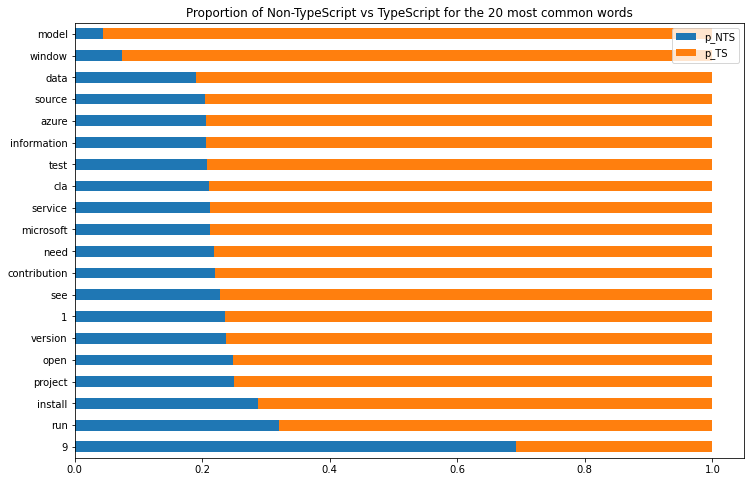

In [15]:
plt.figure(figsize = (12, 8))

# figure out the percentage
(word_counts
 .assign(p_TS=word_counts.NTS / word_counts['all'],
         p_NTS=word_counts.TS / word_counts['all'])
 .sort_values(by='all')
 [['p_NTS', 'p_TS']]
 .tail(20)
 .sort_values('p_TS')
 .plot.barh(stacked=True,figsize = (12, 8)))



plt.title('Proportion of Non-TypeScript vs TypeScript for the 20 most common words')

Text(0.5, 1.0, 'Proportion of TypeScript vs Non-TypeScript for the 20 most common words')

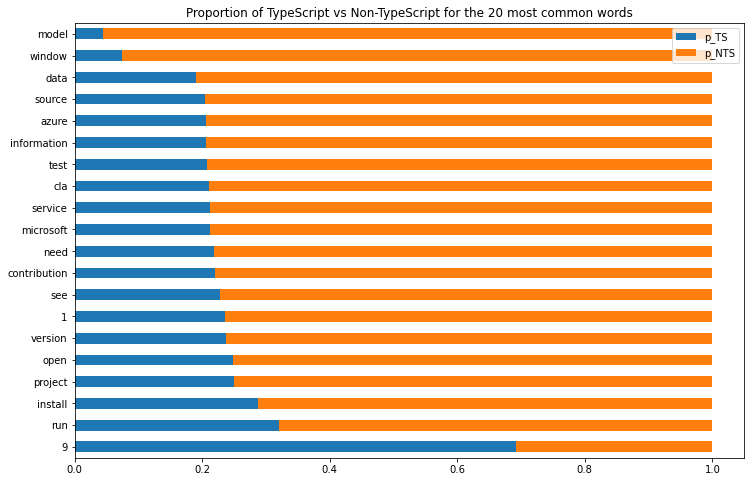

In [177]:
# figure out the percentage
(word_counts
 .assign(p_NTS=word_counts.NTS / word_counts['all'],
         p_TS=word_counts.TS / word_counts['all'])
 .sort_values(by='all')
 [['p_TS', 'p_NTS']]
 .tail(20)
 .sort_values('p_NTS')
 .plot.barh(stacked=True,figsize = (12, 8)))



plt.title('Proportion of TypeScript vs Non-TypeScript for the 20 most common words')

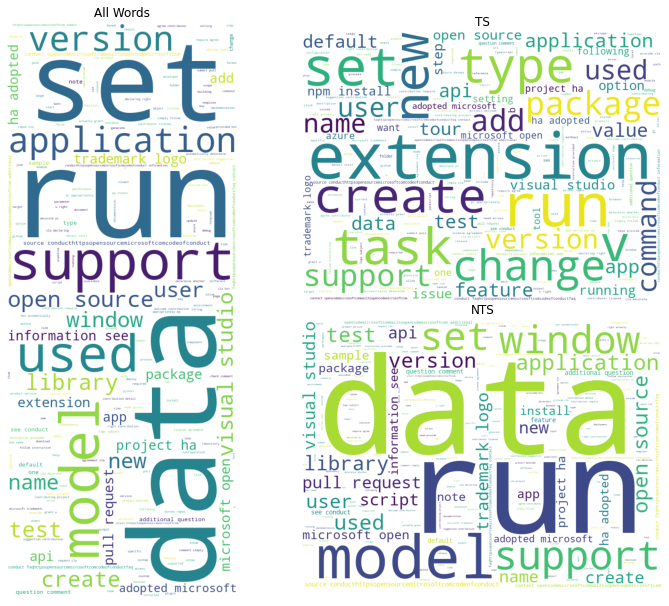

In [18]:
#Create Word Clouds 

all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
TS_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(TS_words))
NTS_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(NTS_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(TS_cloud)
axs[2].imshow(NTS_cloud)

axs[0].set_title('All Words')
axs[1].set_title('TS')
axs[2].set_title('NTS')

for ax in axs: ax.axis('off')

In [19]:
#Bi-grams

top_20_TS_bigrams = (pd.Series(nltk.ngrams(TS_words, 2))
                      .value_counts()
                      .head(20))

top_20_TS_bigrams

(9, 9)                                                            159
(open, source)                                                    158
(visual, studio)                                                  154
(npm, install)                                                    145
(microsoft, open)                                                 142
(trademark, logo)                                                 139
(ha, adopted)                                                     130
(project, ha)                                                     130
(adopted, microsoft)                                              129
(source, conducthttpsopensourcemicrosoftcomcodeofconduct)         129
(information, see)                                                129
(question, comment)                                               127
(additional, question)                                            126
(see, conduct)                                                    126
(conduct, faqhttpsop

In [20]:
top_20_NTS_bigrams = (pd.Series(nltk.ngrams(NTS_words, 2))
                      .value_counts()
                      .head(20))

top_20_NTS_bigrams

(open, source)                                                    594
(pull, request)                                                   531
(trademark, logo)                                                 527
(visual, studio)                                                  518
(microsoft, open)                                                 487
(information, see)                                                444
(project, ha)                                                     441
(ha, adopted)                                                     437
(adopted, microsoft)                                              436
(source, conducthttpsopensourcemicrosoftcomcodeofconduct)         433
(question, comment)                                               433
(see, conduct)                                                    429
(additional, question)                                            429
(contact, opencodemicrosoftcommailtoopencodemicrosoftcom)         417
(opencodemicrosoftco

In [21]:
top_20_all_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_all_bigrams

(open, source)                                                    752
(visual, studio)                                                  672
(trademark, logo)                                                 666
(pull, request)                                                   653
(microsoft, open)                                                 629
(information, see)                                                573
(project, ha)                                                     571
(ha, adopted)                                                     567
(adopted, microsoft)                                              565
(source, conducthttpsopensourcemicrosoftcomcodeofconduct)         562
(question, comment)                                               560
(see, conduct)                                                    555
(additional, question)                                            555
(contact, opencodemicrosoftcommailtoopencodemicrosoftcom)         540
(conduct, faqhttpsop

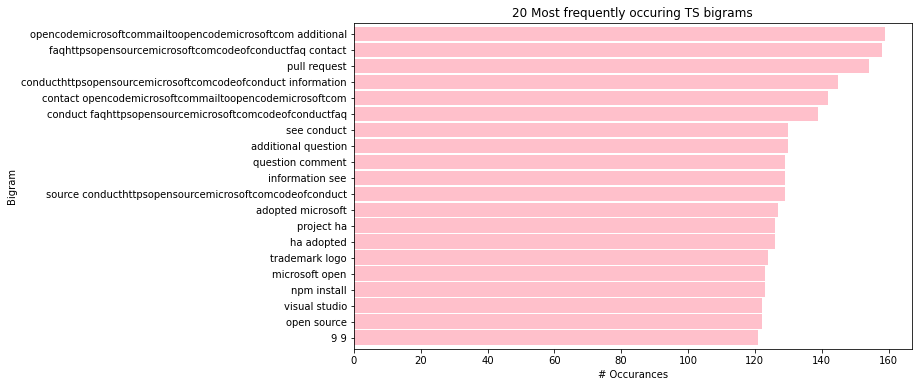

In [22]:
top_20_TS_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring TS bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_TS_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

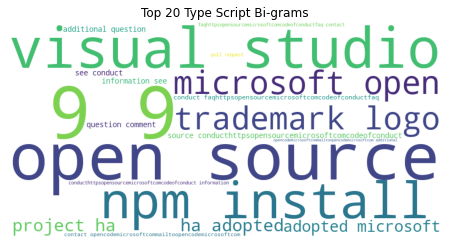

In [40]:
#Bigram Word Clouds

# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_TS_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 Type Script Bi-grams')
plt.show()

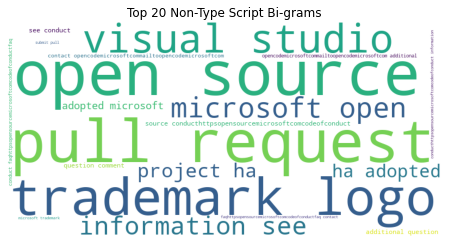

In [41]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_NTS_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 Non-Type Script Bi-grams')
plt.show()

In [42]:
# Does the length of the README vary by programming language?

train.groupby('language').clean.size()

language
AL                    1
ANTLR                 1
Assembly              1
Batchfile             1
Bicep                 1
C                    32
C#                  146
C++                  70
CMake                 1
CSS                   7
CodeQL                1
Dafny                 1
Dockerfile            8
F#                    3
Go                   11
HCL                   3
HTML                 21
JSON                  1
Java                 19
JavaScript           65
Julia                 1
Jupyter Notebook     28
Kotlin                4
Liquid                1
MATLAB                1
Mustache              1
Objective-C           2
Objective-C++         1
PHP                   7
PLpgSQL               1
PowerShell           48
Python              118
Q#                    1
R                     1
Ruby                  5
Rust                  6
SCSS                  3
Scala                 5
ShaderLab             1
Shell                17
Swift                 1
TSQL   

In [27]:
train.clean.str.len()

153     1156
560     6981
1354    5221
1158    1831
1343    2141
        ... 
240     5300
835     7451
983     1823
366     5728
206     4326
Name: clean, Length: 876, dtype: int64

In [44]:
train.head()

,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript
153,microsoft/AppCenter-Test-Appium-Java-Extensions,Java,appium java extensions this project provides e...,appium java extension project provides extensi...,157,1156,False
560,microsoft/PowerApps-Language-Tooling,C#,imagehttpsimgshieldsiogithubworkflowstatusmicr...,imagehttpsimgshieldsiogithubworkflowstatusmicr...,1019,6981,False
1354,microsoft/vscode-remote-try-php,Dockerfile,try out development containers php\r \r a deve...,try development container php development cont...,783,5221,False
1158,microsoft/Dr-Jekyll-and-Mr-Hyde-The-Strange-Ca...,Python,project code for the neurips 2021 paper dr jek...,project neurips 2021 paper dr jekyll mr hyde s...,257,1831,False
1343,microsoft/ai.ed,TypeScript,aied this is the ai for programming education ...,aied ai programming education project goal pro...,311,2141,True


In [59]:
# Get a list of the unique words for lemmatized with stopwords removed
unique_words_lemma = pd.Series(' '.join(train.lemma_no_stopwords.astype('str')).split()).value_counts()
unique_words_lemma.head()

project      3202
microsoft    2814
run          2171
9            1885
azure        1875
dtype: int64

In [60]:
# Get a list of the unique words with cleaned content but not lemmatized and with stopwords still included
unique_words_cleaned = pd.Series(' '.join(train.clean.astype('str')).split()).value_counts()
unique_words_cleaned.head()

the    31048
to     18958
and    13614
a      11786
of      9668
dtype: int64

### Q.) Does the length of the README vary by programming language?

In [31]:
train.groupby('language')['readme_char_count','clean_word_count'].mean().sort_values(by='clean_word_count')

,readme_char_count,clean_word_count
language,,
Dafny,206.000000,28.000000
PLpgSQL,883.000000,120.000000
TeX,1526.000000,207.000000
CodeQL,1885.000000,247.000000
F#,2067.333333,249.666667
Bicep,1823.000000,257.000000
VBScript,1956.000000,268.000000
SCSS,2463.000000,333.666667
R,2666.000000,355.000000


In [32]:
train.groupby('language')['readme_char_count','clean_word_count'].mean()

,readme_char_count,clean_word_count
language,,
AL,3564.000000,522.000000
ANTLR,9727.000000,1325.000000
Assembly,6822.000000,1114.000000
Batchfile,3966.000000,523.000000
Bicep,1823.000000,257.000000
C,5440.906250,754.968750
C#,6267.787671,758.787671
C++,6473.700000,844.057143
CMake,10742.000000,1369.000000


#### README lengths do seem to vary by programming language.
   - MATLAB repos are the largest READMEs and Dafny repos are the smallest.

### Q) What does the distribution of IDFs look like for the most common words?

In [48]:
train.head()

,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript
153,microsoft/AppCenter-Test-Appium-Java-Extensions,Java,appium java extensions this project provides e...,appium java extension project provides extensi...,157,1156,False
560,microsoft/PowerApps-Language-Tooling,C#,imagehttpsimgshieldsiogithubworkflowstatusmicr...,imagehttpsimgshieldsiogithubworkflowstatusmicr...,1019,6981,False
1354,microsoft/vscode-remote-try-php,Dockerfile,try out development containers php\r \r a deve...,try development container php development cont...,783,5221,False
1158,microsoft/Dr-Jekyll-and-Mr-Hyde-The-Strange-Ca...,Python,project code for the neurips 2021 paper dr jek...,project neurips 2021 paper dr jekyll mr hyde s...,257,1831,False
1343,microsoft/ai.ed,TypeScript,aied this is the ai for programming education ...,aied ai programming education project goal pro...,311,2141,True


In [55]:
train.shape

(876, 7)

In [12]:
word_counts = (pd.concat([all_freq, TS_freq, NTS_freq], axis=1, sort=True)
                .set_axis(['all', 'TS', 'NTS'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,TS,NTS
0,398,127,271
00,74,1,73
000,17,0,17
0000,5,0,5
000000,2,0,2


In [39]:
#Look at the ratio between the words

(word_counts
 [(word_counts.NTS > 10) & (word_counts.TS > 10)]
 .assign(ratio=lambda df: df.NTS / (df.TS + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,TS,NTS,ratio
chart,151,124,27,0.217724
typescript,211,171,40,0.233904
survey,57,46,11,0.239078
intellisense,56,45,11,0.244390
k,60,47,13,0.276537
python,707,48,659,13.726307
linux,459,30,429,14.295235
learning,383,19,364,19.147817
model,1318,59,1259,21.335367
powershell,367,12,355,29.558701


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(train.lemma_no_stopwords)

In [72]:
pd.DataFrame(bag_of_words.todense(), columns=tfidf.get_feature_names())

,00,000,0000,000000,00000000,00000000000000000000000000000000,0000000000000000000000000000000000000000,0000000000000000aaaaaaaaaaaaaaaa,000001,000001163jpg,...,zz,zza,zzc1v,zzgkuu5emjwgy,zzhifxzjtfwg6,zzt6iwiwzukzl8rfk,zztazwihbirjbdgrjzg,zzvn2m,zzvr0wx4bb1qgdhdqx2m2q9jqd9,zzxzzrivxr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
tfidf_lemma = pd.Series(dict(zip(tfidf.get_feature_names(), tfidf.idf_))).sort_values()


In [88]:
tfidf_lemma.head(10)

microsoft      1.191716
see            1.193098
project        1.211242
information    1.236921
ha             1.248549
source         1.250012
open           1.272219
question       1.356512
additional     1.363048
need           1.371279
dtype: float64

(array([2., 1., 1., 2., 1., 0., 0., 0., 0., 3.]),
 array([1.1917156 , 1.20967189, 1.22762819, 1.24558448, 1.26354077,
        1.28149707, 1.29945336, 1.31740965, 1.33536595, 1.35332224,
        1.37127853]),
 <BarContainer object of 10 artists>)

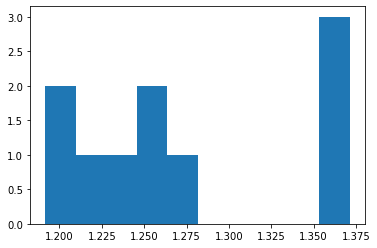

In [89]:
plt.hist(tfidf_lemma.head(10))

In [104]:
train['message_length'] = train.lemma_no_stopwords.apply(len)

In [105]:
train['word_count'] =train.lemma_no_stopwords.apply(str.split).apply(len)

train.head()

,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript,message_length,word_count
153,microsoft/AppCenter-Test-Appium-Java-Extensions,Java,appium java extensions this project provides e...,appium java extension project provides extensi...,157,1156,False,877,90
560,microsoft/PowerApps-Language-Tooling,C#,imagehttpsimgshieldsiogithubworkflowstatusmicr...,imagehttpsimgshieldsiogithubworkflowstatusmicr...,1019,6981,False,5100,578
1354,microsoft/vscode-remote-try-php,Dockerfile,try out development containers php\r \r a deve...,try development container php development cont...,783,5221,False,3747,442
1158,microsoft/Dr-Jekyll-and-Mr-Hyde-The-Strange-Ca...,Python,project code for the neurips 2021 paper dr jek...,project neurips 2021 paper dr jekyll mr hyde s...,257,1831,False,1390,151
1343,microsoft/ai.ed,TypeScript,aied this is the ai for programming education ...,aied ai programming education project goal pro...,311,2141,True,1552,169


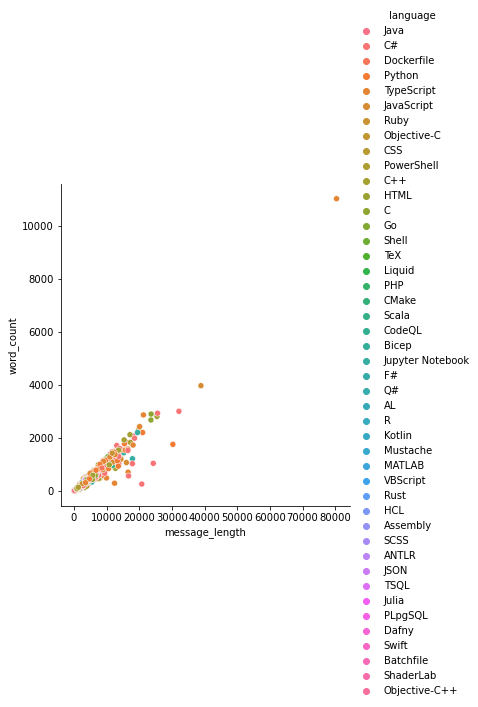

In [111]:
sns.relplot(data = train.head(1000), x = 'message_length', y = 'word_count', hue = 'language')

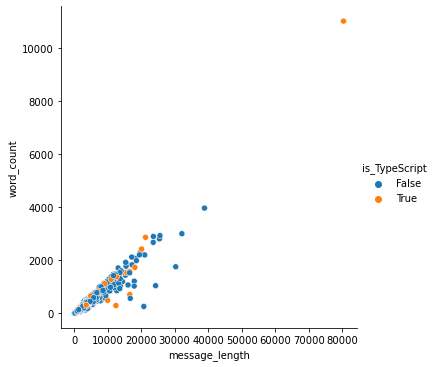

In [138]:
sns.relplot(data = train.head(5000), x = 'message_length', y = 'word_count', hue = 'is_TypeScript')

In [113]:
train.groupby('language').message_length.agg(['mean', 'median'])

,mean,median
language,,
AL,2617.000000,2617.0
ANTLR,7261.000000,7261.0
Assembly,5107.000000,5107.0
Batchfile,3160.000000,3160.0
Bicep,1361.000000,1361.0
C,4218.937500,2533.5
C#,5049.061644,3008.0
C++,5061.285714,3673.5
CMake,8446.000000,8446.0


In [123]:
mean_med = train.groupby('is_TypeScript').message_length.agg(['mean', 'median'])

<Figure size 432x288 with 0 Axes>

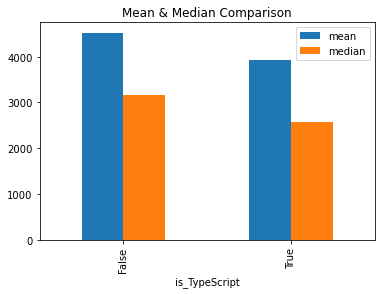

In [132]:
plt.figure()

mean_med.plot(kind="bar")
plt
plt.title('Mean & Median Comparison');

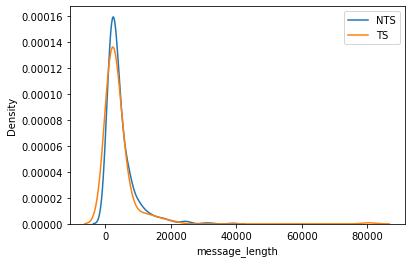

In [135]:
# check out the distributions
sns.kdeplot(train[train.is_TypeScript == False].message_length, label = 'NTS')
sns.kdeplot(train[train.is_TypeScript == True].message_length, label = 'TS')
plt.legend()
plt.show()

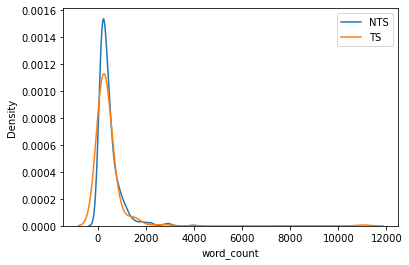

In [136]:
sns.kdeplot(train[train.is_TypeScript == False].word_count, label = 'NTS')
sns.kdeplot(train[train.is_TypeScript == True].word_count, label = 'TS')
plt.legend()
plt.show()

### Hypothesis

#### 1.) Is the message length independent of the programming language?

$H_0$: The mean message length for TypeScript is the same as the mean for all other programming languages.

$H_a$: The mean message length for TypeScript is not the same as the mean for all other programming languages.

In [156]:
alpha = 0.05

In [149]:
#Create boolean masks
is_TypeScript = train.language == 'TypeScript'

In [150]:
is_not_TypeScript = train.language != 'TypeScript'

In [152]:
t, p = stats.mannwhitneyu(train[is_TypeScript].message_length,train[is_not_TypeScript].message_length, alternative = 'two-sided' )

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 61702.000
p = 0.000


In [157]:
if p < alpha:
    print ("We reject the null hypothesis with 95% confidence.")
else:
    print ("We accept the null hypothesis because the results did not pass the 95% confidence level.")

We reject the null hypothesis with 95% confidence.


#### 2.) Does the word 'model' occur statistically more often in TypeScript documents than in other languages?

$H_0$: The word 'model' does not occur more often in non-TypeScript documents than in TypeScript.

$H_a$: The word 'model' does occur more often in non-TypeScript documents than in TypeScript.

In [158]:
alpha = 0.05

In [159]:
train.head()

,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript,message_length,word_count
153,microsoft/AppCenter-Test-Appium-Java-Extensions,Java,appium java extensions this project provides e...,appium java extension project provides extensi...,157,1156,False,877,90
560,microsoft/PowerApps-Language-Tooling,C#,imagehttpsimgshieldsiogithubworkflowstatusmicr...,imagehttpsimgshieldsiogithubworkflowstatusmicr...,1019,6981,False,5100,578
1354,microsoft/vscode-remote-try-php,Dockerfile,try out development containers php\r \r a deve...,try development container php development cont...,783,5221,False,3747,442
1158,microsoft/Dr-Jekyll-and-Mr-Hyde-The-Strange-Ca...,Python,project code for the neurips 2021 paper dr jek...,project neurips 2021 paper dr jekyll mr hyde s...,257,1831,False,1390,151
1343,microsoft/ai.ed,TypeScript,aied this is the ai for programming education ...,aied ai programming education project goal pro...,311,2141,True,1552,169


In [170]:
#Get the number of 'model' in content

model_count_list = []

for document in train.lemma_no_stopwords:
    
    word_list = str(document).split()
    
    i = 0
    
    for word in word_list:
        
        if word == 'model':
            i += 1

    model_count_list.append(i)
    
model_count_series = pd.Series(model_count_list)

train['preserve_index'] = train.index

train = train.reset_index()

train['model_word_counts'] = model_count_series

train.head()

,index,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript,message_length,word_count,model_word_counts,preserve_index
0,153,microsoft/AppCenter-Test-Appium-Java-Extensions,Java,appium java extensions this project provides e...,appium java extension project provides extensi...,157,1156,False,877,90,0,153
1,560,microsoft/PowerApps-Language-Tooling,C#,imagehttpsimgshieldsiogithubworkflowstatusmicr...,imagehttpsimgshieldsiogithubworkflowstatusmicr...,1019,6981,False,5100,578,0,560
2,1354,microsoft/vscode-remote-try-php,Dockerfile,try out development containers php\r \r a deve...,try development container php development cont...,783,5221,False,3747,442,0,1354
3,1158,microsoft/Dr-Jekyll-and-Mr-Hyde-The-Strange-Ca...,Python,project code for the neurips 2021 paper dr jek...,project neurips 2021 paper dr jekyll mr hyde s...,257,1831,False,1390,151,0,1158
4,1343,microsoft/ai.ed,TypeScript,aied this is the ai for programming education ...,aied ai programming education project goal pro...,311,2141,True,1552,169,0,1343


In [169]:
train['preserve_index'] = train.index
train.head()

,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript,message_length,word_count,model_word_counts,preserve_index
153,microsoft/AppCenter-Test-Appium-Java-Extensions,Java,appium java extensions this project provides e...,appium java extension project provides extensi...,157,1156,False,877,90,0.0,153
560,microsoft/PowerApps-Language-Tooling,C#,imagehttpsimgshieldsiogithubworkflowstatusmicr...,imagehttpsimgshieldsiogithubworkflowstatusmicr...,1019,6981,False,5100,578,0.0,560
1354,microsoft/vscode-remote-try-php,Dockerfile,try out development containers php\r \r a deve...,try development container php development cont...,783,5221,False,3747,442,NaN,1354
1158,microsoft/Dr-Jekyll-and-Mr-Hyde-The-Strange-Ca...,Python,project code for the neurips 2021 paper dr jek...,project neurips 2021 paper dr jekyll mr hyde s...,257,1831,False,1390,151,NaN,1158
1343,microsoft/ai.ed,TypeScript,aied this is the ai for programming education ...,aied ai programming education project goal pro...,311,2141,True,1552,169,NaN,1343


In [171]:
train.model_word_counts.unique()

array([ 0,  6, 23,  1, 15,  3,  2, 18, 32,  8,  4, 13, 29,  9,  7, 12, 40,
        5, 37, 63, 20, 60, 10, 16, 11, 19, 21, 25, 14, 43, 28])

In [173]:
#Create boolean masks

is_TypeScript = train.language == 'TypeScript'
is_not_TypeScript = train.language != 'TypeScript'

In [176]:
t, p = stats.mannwhitneyu(train[is_TypeScript].model_word_counts,train[is_not_TypeScript].model_word_counts, alternative = 'less' )

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 59192.500
p = 0.000


In [178]:
if p < alpha:
    print ("We reject the null hypothesis with 95% confidence.")
else:
    print ("We accept the null hypothesis because the results did not pass the 95% confidence level.")

We reject the null hypothesis with 95% confidence.
